In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Customer_Churn_Prediction')

Mounted at /content/drive


In [ ]:
import joblib
import pandas as pd
from split import split_data
import numpy as np
from error_analysis import classification_summary
rf_model  = joblib.load("/content/drive/MyDrive/Customer_Churn_Prediction/final_rf_model.pkl")
xgb_model = joblib.load("/content/drive/MyDrive/Customer_Churn_Prediction/final_xgb_model.pkl")

config = joblib.load("/content/drive/MyDrive/Customer_Churn_Prediction/final_ensemble_config.pkl")

weights   = config["weights"]
threshold = config["threshold"]

/usr/lib/python3.12/pickle.py:1760: UserWarning: [20:32:51] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Customer_Churn_Prediction/Telco-Customer-Churn-Final.csv")

In [ ]:
x = df.drop(columns="Churn", errors="ignore")
y = df["Churn"].astype(int)
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x,y)

In [ ]:
# expected config format:
# {
#   "weights": {"rf": 0.4, "xgb": 0.6},
#   "threshold": 0.5
# }

weight_dict = config["weights"]
threshold   = float(config.get("threshold", 0.5))

# enforce correct order
model_dict = {
    "rf": rf_model,
    "xgb": xgb_model
}

weights = np.array(
    [float(weight_dict[k]) for k in model_dict.keys()],
    dtype=float
)

weights = weights / weights.sum()  # normalize

print("Weights:", weights)
print("Threshold:", threshold)


Weights: [0.5 0.5]
Threshold: 0.39174267538245766


In [ ]:
assert hasattr(rf_model, "predict_proba")
assert hasattr(xgb_model, "predict_proba")

print("RF classes :", rf_model.classes_)
print("XGB classes:", xgb_model.classes_)

RF classes : [0 1]
XGB classes: [0 1]


In [ ]:
def soft_voting(models, weights, X, threshold=0.5):
    probs = np.zeros(len(X), dtype=float)

    for model, w in zip(models, weights):
        probs += w * model.predict_proba(X)[:, 1]

    y_pred = (probs >= threshold).astype(int)
    return y_pred, probs

In [ ]:
models = list(model_dict.values())

y_pred, y_prob = soft_voting(
    models=models,
    weights=weights,
    X=x_test,
    threshold=threshold
)

In [ ]:
print("Predictions:", y_pred[:10])
print("Probabilities:", y_prob[:10])

Predictions: [1 1 0 1 1 0 0 0 0 0]
Probabilities: [0.62802726 0.48167634 0.36332441 0.67018286 0.96452375 0.11279738
 0.07687843 0.00997043 0.21565109 0.02393024]


In [ ]:
print(classification_summary(y_test, y_pred))

{'confusion_matrix':           Pred_0  Pred_1
Actual_0     379     140
Actual_1      56     460, 'metrics': {'accuracy': 0.8106280193236715, 'precision': 0.7666666666666667, 'recall': 0.8914728682170543, 'f1': 0.8243727598566308}, 'error_breakdown': {'TP': np.int64(460), 'FP': np.int64(140), 'FN': np.int64(56), 'TN': np.int64(379)}, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.87      0.73      0.79       519\n           1       0.77      0.89      0.82       516\n\n    accuracy                           0.81      1035\n   macro avg       0.82      0.81      0.81      1035\nweighted avg       0.82      0.81      0.81      1035\n'}


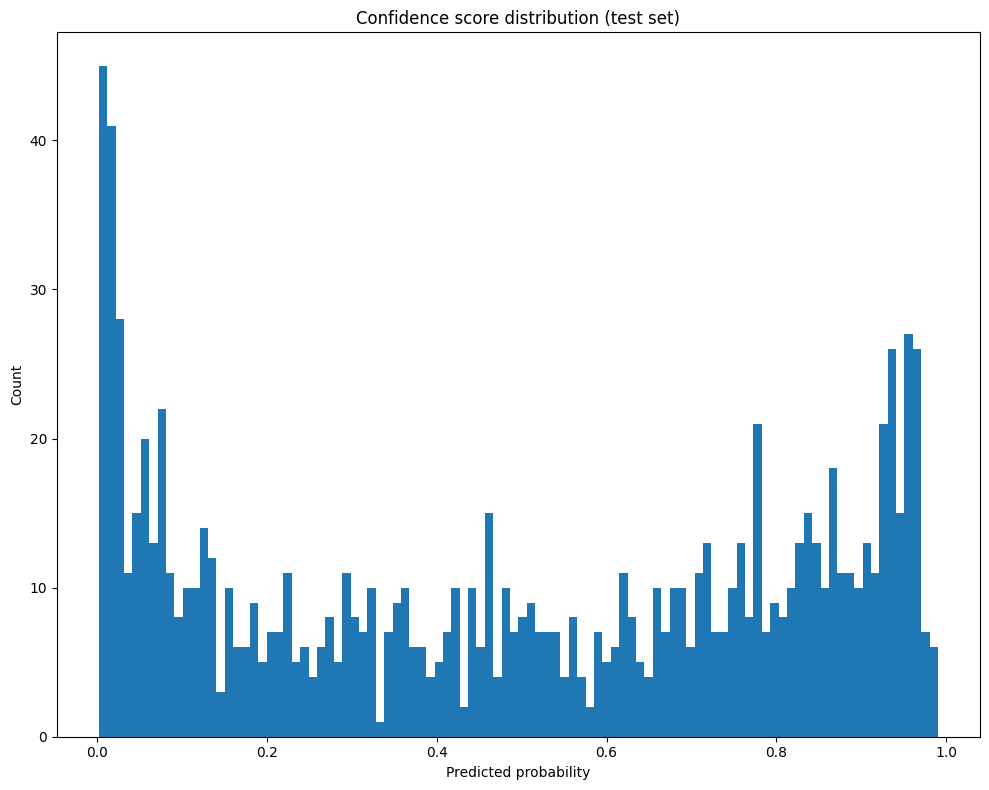

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.hist(y_prob, bins=100)
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Confidence score distribution (test set)")
plt.tight_layout()
plt.show()

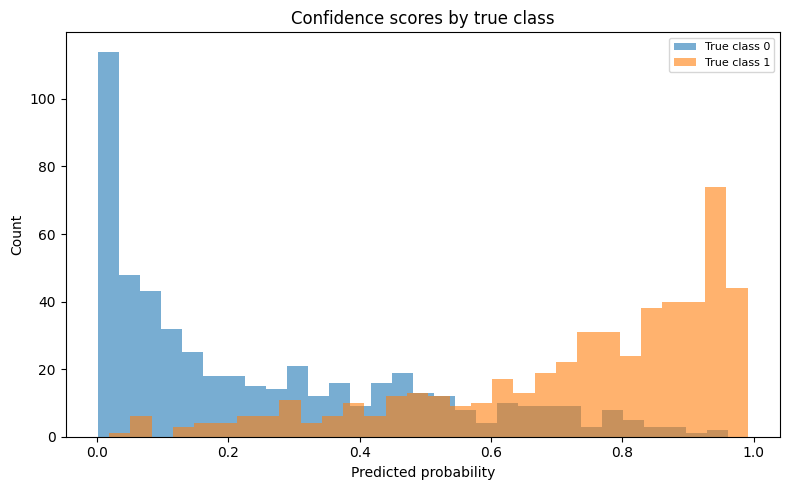

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(y_prob[y_test == 0], bins=30, alpha=0.6, label="True class 0")
plt.hist(y_prob[y_test == 1], bins=30, alpha=0.6, label="True class 1")

plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Confidence scores by true class")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

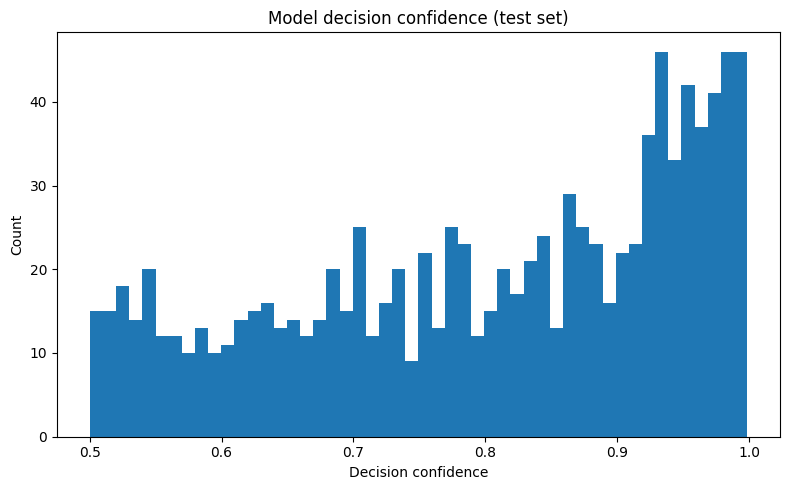

In [ ]:
confidence = np.maximum(y_prob, 1 - y_prob)

plt.figure(figsize=(8, 5))
plt.hist(confidence, bins=50)
plt.xlabel("Decision confidence")
plt.ylabel("Count")
plt.title("Model decision confidence (test set)")
plt.tight_layout()
plt.show()

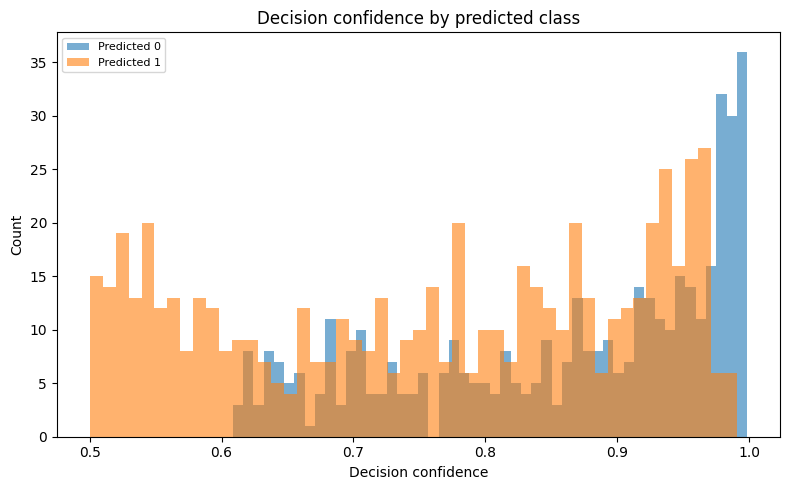

In [ ]:
y_pred = (y_prob >= threshold).astype(int)
confidence = np.maximum(y_prob, 1 - y_prob)

plt.figure(figsize=(8, 5))
plt.hist(confidence[y_pred == 0], bins=50, alpha=0.6, label="Predicted 0")
plt.hist(confidence[y_pred == 1], bins=50, alpha=0.6, label="Predicted 1")

plt.xlabel("Decision confidence")
plt.ylabel("Count")
plt.title("Decision confidence by predicted class")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()